# Introduction to Recurrent Neural Networks (RNNs)

## Learning stock embeddings for price movement classification using bidirectional RNNs

In [90]:
#Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## Recurrent Neural Networks (RNNs) - An intro to sequence classification, and an aside on LSTMs

To get you started, we look at a simple example built specifically for RNNs - digit sequence classification. We define the problem as follows: assume you are an airline company running baggage checks at the airport. The maximum total baggaged weight allowed for the flight is 1570 pounds. We classify a baggage weight with label 0 if the cumulative sum so far is lesser than the threshold, and 1 if it goes above the threshold. Also assume that the length of all sequences is 35. For example:

Sequence: 500, 500, 500, 327, 294, 102, ...  
Labels  : 0  , 0  , 0  , 1  , 1  , 1, ...

We will also plot confusion matrices and accuracy plots to inform our decisions about the model.


### Data Generation

Generate sequence data using the functions defined below:

In [91]:
baggage_threshold = 1570
sequence_len = 35

def generate_sequence(sequence_len):
    data = np.random.choice(521, sequence_len) #generate random ints in the given range
    labels = np.array([0 if np.sum(data[: i+1]) <= 1570 else 1 for i in range(len(data))])
    
    return data, labels


In [92]:
#construct data matrix X and labels y

X = np.zeros((1000, 35))
y = np.zeros((1000, 35))

for row in range(X.shape[0]): 
    x_gen, y_gen = generate_sequence(sequence_len)
    X[row, :] = x_gen
    y[row, :] = y_gen
    
#split into training and testing data using an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Models

Now, we train a simple RNN to classify our data! We will be using binary cross-entropy loss, which you will see later in this notebook as well.  Here is some starter code to help you out:

In [93]:
from keras.layers import SimpleRNN, LSTM, Bidirectional, TimeDistributed, Dense
from keras.models import Sequential

model_1 = Sequential()
model_1.add(SimpleRNN(20, input_shape = (35, 1), return_sequences = True))
#add an output layer (Hint: Look up sigmoid activation)
model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_1.fit(X, y, verbose = False)

Now, let's check our model accuracy on the test set: 

In [94]:
model_1.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 2ms/step - loss: 0.3427 - accuracy: 0.9053


[0.34268832206726074, 0.9052857160568237]

In [95]:
#import seaborn to plot the confusion matrix
import seaborn as sn

In [96]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_1.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]

In [97]:
#flatten y_test values into a list
actual = []
for row in range(len(y_test)): 
    actual += list(y_test[row])

In [98]:
#horizontal axis is predicted label, vertical axis is actual label
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat)
df_cm

,0,1
0,623,525
1,138,5714


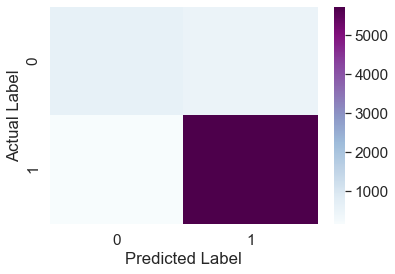

In [99]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


Not bad! Although we have a high overall accuracy, the confusion matrix shows that there are many terms with an actual label of 0 that are classifier predicts to be 1. Let's see if we can do better using LSTMs (a form of RNNs, refer to the note for more details) - make a new model that uses an LSTM layer instead of a simple RNN. Notice that it makes sense to use LSTMs here because we would like our model to remember earlier baggage weights to classify future baggage weights in the sequence.

In [100]:
model_2 = Sequential()
model_2.add(LSTM(20, input_shape = (35, 1), return_sequences = True))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_2.fit(X, y, verbose = False)

In [101]:
model_2.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 4ms/step - loss: 0.1737 - accuracy: 0.9323


[0.1737445443868637, 0.932285726070404]

In [102]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_2.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]


In [103]:
#generate confusion matrix
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat, range(2), range(2))
df_cm

,0,1
0,740,408
1,66,5786


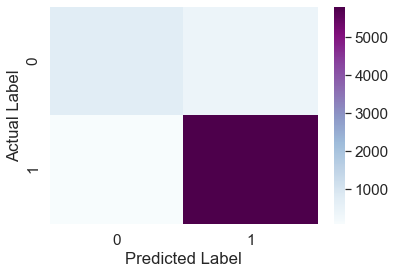

In [104]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


Even better! As you can see from the confusion matrix, there are fewer false positives, i.e. terms that are predicted to be under label 1 but are actually under label 0. Now let's try using a Bidirectional LSTM as our model:

In [105]:
model_3 = Sequential()
model_3.add(Bidirectional(LSTM(20, input_shape = (35, 1), return_sequences = True)))
model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_3.fit(X, y, verbose = False)

In [106]:
model_3.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 3ms/step - loss: 0.1558 - accuracy: 0.9461


[0.1558298021554947, 0.946142852306366]

In [107]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_3.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]

#generate confusion matrix
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat, range(2), range(2))
df_cm


,0,1
0,910,238
1,139,5713


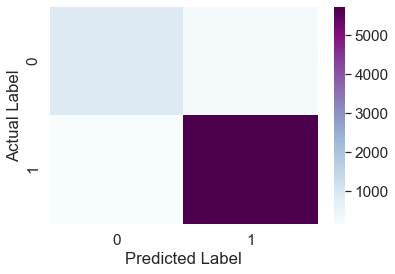

In [108]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()

### Plot accuracy over epochs for all three models

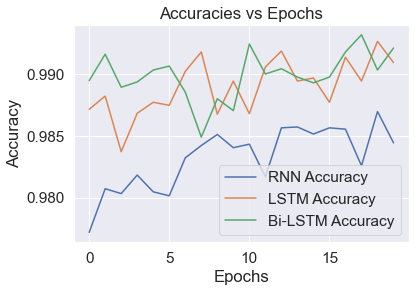

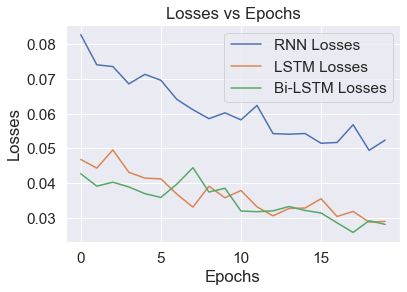

In [110]:
num_epochs = 20

model_1_history = model_1.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)
    
train_losses_1 = model_1_history.history['loss']
train_accuracies_1 = model_1_history.history['accuracy']

model_2_history = model_2.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)

train_losses_2 = model_2_history.history['loss']
train_accuracies_2 = model_2_history.history['accuracy']

model_3_history = model_3.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)

train_losses_3 = model_3_history.history['loss']
train_accuracies_3 = model_3_history.history['accuracy']

plt.figure()
plt.title("Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="RNN Accuracy")
plt.plot(train_accuracies_2, label="LSTM Accuracy")
plt.plot(train_accuracies_3, label="Bi-LSTM Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.title("Losses vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(train_losses_1, label="RNN Losses")
plt.plot(train_losses_2, label="LSTM Losses")
plt.plot(train_losses_3, label="Bi-LSTM Losses")
plt.legend()
plt.show()


Note here that in the Bidirectional case, you may have either gotten a marginal increase in accuracy or a slight decrease in accuracy, depending on how your sequences were generated. While this example was specifically desgined to make RNNs and LSTMs shine, we hope this gives you an appreciation for the kinds of problems we can solve using Recurrent Networks, and how improvements can be made to the simple RNN architecture. Now, we will try to use RNNs to tackle a much harder problem - stock price classification!

## Using Bi-GRUs for price movement classification

For the purposes of this assignment, we will focus on training a classifier for stocks from the S&P 500. The goal of our classifier is as follows:
We are interested in training a bidirectional RNN model that learns a relationship between news taglines related to the stocks $\{l_i\}$ that we have selected and the prices of those stocks. Define $p_i^{(t)}$ to be the price of stock $l_i$ on day $t$. Then, we can formally define our objective as follows:

Let $y_i^{(t)} = \begin{cases} 1 & p_i^{(t)} \geq p_i^{(t - 1)} \\ 0 & p_i^{(t)} < p_i^{(t - 1)} \end{cases}$. Suppose our dataset $D = \{N^{(t)}\}_{t_{in} \leq t \leq t_f}$, where $N^{(t)}$ is a collection of all the articles from day $t$ and $t_{in}$ and $t_f$ represent the dates of the earliest and latest articles in our dataset resepctively. Then, we want to learn a mapping $\hat y_i^{(t)} = f(N^{(t - \mu)} \cup \ldots \cup N^{(t)})$ such that $\hat y_i^{(t)}$ accurately predicts $y_i^{(t)}$. More specifically, as is often the case with classification problems, we want to minimize the loss function given by the mean time-series cross-entropy loss:
$$\mathcal{L}_i = \frac{-1}{t_f - t_{in}} \sum_{t = t_{in}}^{t_f} \big(y_i^{(t)} \log \hat y_i^{(t)} + (1 - y_i^{(t)}) \log (1 - \hat y_i^{(t)}\big)$$
Here, we choose to use $\mu = 4$, so we aim to classify the price movement of stock $l_i$ on day $t$, given by $p_i^{(t)}$, using news information from days $[t-4, t]$, i.e., articles $\{N^{(t - 4)}, N^{(t - 3)}, N^{(t - 2)}, N^{(t - 1)}, N^{(t)}\}$. Notice that we are including information from day $t$, so we are not *predicting* the price movement but rather identifying a relationship between the stock price movement and the information contained in the news taglines from day $t$ and the previous 4 days.

## Generating word embeddings

The code below loads word embeddings that we have pre-generated for 15 stocks from the S&P 500. We used news tagline data from Reuters (data sourced from https://github.com/vedic-partap/Event-Driven-Stock-Prediction-using-Deep-Learning/blob/master/input/news_reuters.csv) to create word embeddings for all of the articles in our dataset using a pretrained Spacy encoder and a Word2Vec model that we trained on our data (don't worry if you don't know what this means yet). Our dataset contains news articles from 2011 to 2017 so we should have enough data to build a fairly accurate classifier. You will explore algorithms for generating word embeddings in more detail later in the course but for this assignment, we have done the work for you so that you can focus on building RNN models for your stock movement classifier.

For the purposes of our classifier, we are focusing on the 15 stocks from the Reuters dataset for which we have the most data, i.e., news articles.

<br>

The main idea is to convert all of the qualitative textual information that we have in each article tagline into a quantitative feature that we can use when training our classifier. Let $s_i \in \mathbb{R}^{64}$ represent the stock embedding that we are trying to learn for stock $l_i$. We then define the following quantities:

Let $n_i^{(t)}$ be a news article from day $t$, for some $1 \leq i \leq |N^{(t)}|$. We associate an embedding vector $K_i^{(t)} \in \mathbb{R}^{64}$ with each article $n_i^{(t)}$, which we have computed for you below.

In [103]:
data = pd.read_csv("embeddings.csv")
cols_to_include = ["Date", "Ticker", "Headline", "Tagline"] + ["K{}".format(i) for i in range(64)]
data = data[cols_to_include]
data

,Date,Ticker,Headline,Tagline,K0,K1,K2,K3,K4,K5,...,K54,K55,K56,K57,K58,K59,K60,K61,K62,K63
0,20140414,AAPL,Apple antitrust compliance off to a promising ...,"NEW YORK Apple Inc has made a ""promising start...",0.728133,0.074376,-0.844244,0.386816,-0.101627,0.965676,...,-0.894744,-1.209550,0.022297,0.721769,-1.181336,-0.527883,0.618779,-0.460661,-0.654457,0.347296
1,20140414,AAPL,Apple antitrust compliance off to a promising ...,"NEW YORK April 14 Apple Inc has made a ""promi...",0.757790,0.111567,-0.802569,0.333254,-0.060955,0.996661,...,-0.782604,-1.193472,-0.040548,0.738943,-1.186327,-0.449470,0.506322,-0.397205,-0.607989,0.462105
2,20140414,AAPL,COLUMN-How to avoid the trouble coming to the ...,(The opinions expressed here are those of the ...,-0.624152,-0.346050,-1.487509,1.194646,0.050459,0.602637,...,0.091208,-0.098015,-1.472723,0.380068,-1.273030,-0.143687,-0.026395,-0.532428,0.985156,-0.734174
3,20140414,AAPL,How to avoid the trouble coming to the tech se...,CHICAGO A resounding shot across the bow has b...,0.387120,-0.099557,-0.590867,-0.532860,0.078823,0.575159,...,-0.222005,-1.005797,-0.873272,1.010729,-1.111801,0.090758,-0.138770,0.328208,-0.856174,-0.269537
4,20140415,AAPL,Apple cannot escape U.S. states' e-book antitr...,NEW YORK Apple Inc on Tuesday lost an attempt ...,0.824634,-1.637257,-0.352775,-0.604853,-0.010361,0.771431,...,-0.158041,-1.782186,-0.321180,0.213456,-0.865087,0.074308,0.301620,0.198198,-0.107721,0.127805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50787,20170209,TAPR,BRIEF-Ultra Petroleum says Barclays agreed to ...,* Ultra Petroleum- on Feb 8 in connection wit...,1.139437,0.682006,0.029171,-0.304725,-0.776514,0.983443,...,-0.477868,-1.729272,0.025326,0.869954,-0.348191,-0.362264,0.413104,-0.154671,0.886414,0.782220
50788,20170209,TAPR,MOVES-Barclays Nasdaq RenCap AXA BC Partners,Feb 9 The following financial services industr...,1.017802,-0.165982,-0.467275,1.028413,0.571217,0.251248,...,0.389808,-0.710198,-0.832409,-0.209801,-1.864952,1.237639,1.087065,-1.006863,0.256364,-0.714636
50789,20170217,TAPR,Barclays Citi gave South Africa watchdog info...,JOHANNESBURG Feb 17 Barclays Plc and Citigrou...,1.044449,-0.042930,0.201579,0.368795,0.163013,0.535172,...,-0.989387,-1.056570,-0.652724,0.302391,-0.539873,-0.171629,0.472612,0.625271,0.184726,0.232111
50790,20170217,TAPR,Barclays Citi helped South Africa with forex ...,JOHANNESBURG Barclays Plc and Citigroup appr...,1.288937,-0.372697,0.197727,0.622883,0.022204,0.923629,...,-1.169927,-1.494177,-0.431977,0.928176,-0.336484,-0.262020,0.443658,0.316990,-0.013611,-0.358849


Here, each row represents a different news article and is associated with one of the top 15 stocks that we are interested in for our classifier: <br>
`['AAPL', 'AMZN', 'BA', 'BCS', 'BP', 'C', 'DB', 'GM', 'GS', 'HSEA', 'HSEB', 'JPM', 'MSFT', 'MS', 'TAPR']`.

Additionally, the columns `[K0, ..., K63]` represent the components of the $K_i^{(t)}$ embedding vector for each article $n_i^{(t)}$.

## Building a Bi-GRU price movement classifier

We define $score(n_i^{(t)}, s_j) = K_i^{(t)} \cdot s_j$ and the softmax variable $$\alpha_i^{(t)} = \frac{\exp(score(n_i^{(t)}, s_j))}{\sum_{n_k^{(t)} \in N^{(t)}}exp(score(n_k^{(t)}, s_j))}$$

Finally, we define the market status of stock $l_j$ on day $t$, given by $m_j^{(t)} = \sum_{n_i^{(t)} \in N^{(t)}} \alpha_i^{(t)} V_i^{(t)}$. This is the input to the classifier that you will build and train on the dataset to learn the stock embeddings $\{s_j\}$.

Here, we will go through the process of building, training, and tuning our model for a single stock. After this is done, we can easily repeat the process for other stocks.

### 1) a) Data processing

In [3]:
## do it for one stock, AAPL
aapl = data[data['Ticker'] == 'AAPL']
len(aapl)

6674

In [4]:
## set kappa to be max number of articles for a given day
kappa = np.max(aapl.groupby('Date').count()['index'])
kappa

12

In [5]:
## remove dates that have < 4 articles
keep_dates = aapl["Date"].unique()[(aapl.groupby("Date").count()["index"] >= 4)]
keep_indices = [aapl.loc[i, "Date"] in keep_dates for i in aapl.index]

In [8]:
aapl_processed = aapl[keep_indices]

In [9]:
sorted_dates  = sorted(aapl_processed['Date'].unique())
num_sequences = len(sorted_dates[4:])
num_sequences

792

In [10]:
#pad processed df to include kappa entries for each date
pd.options.mode.chained_assignment = None

padded_aapl_proc = aapl_processed.copy(deep = True)

for date in aapl_processed['Date'].unique(): 
    df_date = aapl_processed[aapl_processed['Date'] == date]
    
    if len(df_date) <  kappa: 
        row_append = df_date.head(1)
        #change value and key vec to be 0 for appended rows
        row_append.iloc[:, row_append.columns.get_loc('K0') : row_append.columns.get_loc('V299') + 1] = 0
        
        #temp variable to fix annoying pandas append tendencies
        temp = padded_aapl_proc
        for i in range(kappa - len(df_date)): 
            temp = temp.append(row_append, ignore_index = True)
            
        padded_aapl_proc = temp
    

In [11]:
padded_aapl_proc = padded_aapl_proc.sort_values('Date')

In [12]:
len(padded_aapl_proc)/12

796.0

Now that we have processed our data to include only robust inputs, let's do a quick refresher of what your initial input to the neural network is supposed to look like, and what dimensions it will have. Our key vectors for day $t$ are  $K_i^{(t)} \in \mathbb{R}^{64}$, and we have at most $\kappa$ articles per day. Thus, for any given day $t$, we can treat the input as $\begin{bmatrix} K_1^{(t)} & \cdots & K_\kappa^{(t)} \end{bmatrix} \in \mathbb{R}^{64 \times \kappa}$. Since our network uses five market vectors ($m^{(t - 4)}, \ldots, m^{(t)}$) for predicting stock price movement on any given day, we must pass in a sequence of $\kappa \cdot 5$ key vectors. 

So each input looks like $\begin{bmatrix} K_1^{(t - 4)} & \cdots & K_\kappa^{(t - 4)} & \cdots \cdots & K_1^{(t)} & \cdots & K_\kappa^{(t)} \end{bmatrix} \in \mathbb{R}^{64 \times 5\kappa}$. Then, assuming we have $k$ such datapoints (or in our case, $5$ day sequences) in our training dataset, our input is thus:
$\begin{bmatrix} 
K_1^{(t_1 - 4)} & \cdots & K_\kappa^{(t_1 - 4)} & \cdots \cdots & K_1^{(t_1)} & \cdots & K_\kappa^{(t_1)} \\
\vdots & & \vdots & & \vdots & & \vdots \\
K_1^{(t_k - 4)} & \cdots & K_\kappa^{(t_k - 4)} & \cdots \cdots & K_1^{(t_k)} & \cdots & K_\kappa^{(t_k)}
\end{bmatrix} \in \mathbb{R}^{64k \times 5\kappa}$
where each row represents a different sequence of $5$ days for the stock key vectors.

In [13]:
k = num_sequences
X_in = np.zeros((64*k, 5*kappa))

In [14]:
#iterate through rows, step size of 64 to account for size of key vectors
for i in range(k): 
    dates = sorted_dates[i : i + 5]
    
    #counter to keep track of column index
    counter = 0
    for date in dates: 
        df = aapl_processed[aapl_processed['Date'] == date]
        sub_mat = np.array(df.iloc[:, df.columns.get_loc('K0') : df.columns.get_loc('K63') + 1]).T
        X_in[64 * i : 64 * i + 64, counter : counter + sub_mat.shape[1]] = sub_mat
        
        #increment by kappa to go to next day in sequence
        counter += kappa
        
    

In [17]:
X_in

array([[ 0.84720065,  1.99831985,  1.19001225, ...,  1.27729124,
         0.        ,  0.        ],
       [ 0.01052767, -0.82558529, -0.4053802 , ..., -1.03439441,
         0.        ,  0.        ],
       [-0.99316981, -1.1317625 , -1.35804945, ..., -1.81819254,
         0.        ,  0.        ],
       ...,
       [-0.52824199, -0.17233396,  0.72696523, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52783575, -0.76645522,  0.28038069, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34940266,  0.26867361,  0.95655539, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
X_in.shape

(50688, 60)

### 1) b) Generating classifier labels

The classifier aims to predict price movement -- in this notebook, we define movement in terms of log returns, the difference in log prices for a given day $t$, and a preceding day, $t-1$. Note that due to the nature of the dataset, we do not have a perfectly contiguous sequence of days, however, we use the next best approximation (i.e. $t-2$, if it is available, in place of $t-1$). Using these log returns, we binarize price movement: if returns are $> 0$ on day $t$, then $y^{(t)} = 1$, else $0$. 

You can find historical stock price data on http://finance.yahoo.com, and use close prices to calculate log returns.

For non-trading days, feel free to use any method to fill in the missing data - we generated labels for missing days by doing a coin toss (while this may seem arbitrary, note that the stock market itself moves in what seems like arbitrarily random directions). 

In [18]:
prices = pd.read_csv('AAPL.csv')
prices['log_returns'] = np.log(prices['Close']) - np.log(prices['Close'].shift(1))

In [19]:
#change date format
prices['Date'] = prices['Date'].apply(lambda x: int(x.replace('-', '')))

In [20]:
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns
0,20110131,11.992857,12.144286,11.939285,12.118571,10.369199,377246800,NaN
1,20110201,12.189285,12.344643,12.177857,12.322500,10.543692,426633200,0.016688
2,20110202,12.301785,12.330358,12.269643,12.297143,10.521996,258955200,-0.002060
3,20110203,12.278571,12.294286,12.091071,12.265715,10.495105,393797600,-0.002559
4,20110204,12.272857,12.382143,12.268214,12.375000,10.588613,321840400,0.008870


In [21]:
#generate labels for each of the k sequences for the AAPL stock
labels = []
for date in sorted_dates[4:]:
    log_ret = prices[prices['Date'] == date]['log_returns'].values
    
    if (len(log_ret) == 0): 
        labels.append(np.random.choice([1, 0]))
        continue
    
    if (log_ret[0]) > 0: 
        labels.append(1)
    else: 
        labels.append(0)
    

### 2) Building the classifier model

Before building our main classifier, recall that we need to do some preprocessing to get from our input above to the market vectors that are being used in the classifier. The documentation for tensorflow and Keras will help a lot with some of the manipulations required for this section. In particular, the documentation for `Dense` layers, `GRU` layers, `Activation` layers, `Bidirectional` layers, and `keras.activations.softmax` (which we have imported for you) may be helpful. The outline of the necessary preprocessing steps is as follows:

1. We want our input layer to be a tensor with shape $(k, 5, 64 \kappa)$ <br>
See how you can modify `X_in` $= \begin{bmatrix} 
K_1^{(t_1 - 4)} & \cdots & K_\kappa^{(t_1 - 4)} & \cdots \cdots & K_1^{(t_1)} & \cdots & K_\kappa^{(t_1)} \\
\vdots & & \vdots & & \vdots & & \vdots \\
K_1^{(t_k - 4)} & \cdots & K_\kappa^{(t_k - 4)} & \cdots \cdots & K_1^{(t_k)} & \cdots & K_\kappa^{(t_k)}
\end{bmatrix} \in \mathbb{R}^{64k \times 5\kappa}$ from above to achieve this.
<br>

2. By treating the stock embedding $s$ as a weight from the input layer to the first hidden layer, generate layer 1 of $score$ values of shape $(k, 5, \kappa)$. We can do this because $score_i^{(t)}$ is defined as $K_i^{(t)} \cdot s$, which aligns with the way weights act in neural networks. <br>
*Hint:* Remember that we use `Dense` layers in Keras to represent a regular feedforward layer. 
<br>

3. Apply softmax activations appropriately to generate layer 2 with the $\alpha$ values, also of shape $(k, 5, \kappa)$. <br>
*Hint:* Remember, we define $\alpha_i^{(t)} = \displaystyle \frac{\exp(score_i^{(t)})}{\sum_{j \in [\kappa], j \neq i}exp(score_j^{(t)})}$. You can also combine this step with the previous one if you wish.
<br>

4. Now, implement the Bi-GRU classifier model with $1024$ recurrent units. We will experiment with the number of units later when we conduct our hyperparameter tuning. Remember that for each sequence of 5 vectors that we input to the GRU, we are only interested in the prediction for the last one. That is, given $[\alpha_1^{(t - 4)}, \ldots, \alpha_\kappa^{(t - 4)}], \ldots, [\alpha_1^{(t)}, \ldots, \alpha_\kappa^{(t)}]$, we only care about what the GRU predicts for day $t$ since that is the movement that we are trying to classify.
<br>

5. Finally, apply a dense layer with a sigmoid activation to get a single value $\hat y^{(t)}$ from the GRU output.
<br>

6. Train your model for $10$ epochs against the cross-entropy loss and report the train and validation loss after each epoch.

In [54]:
from keras import backend as K
from keras.layers import Activation, Input, Dense, GRU, Bidirectional, Lambda
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.activations import softmax

#### Step 1

In [56]:
#transform the input X_in from above into an appropriate tensor of shape (k, 5, 64kappa)

X_in_mod = np.zeros((k, 5, 64 * kappa))
for i in range(k):
    for j in range(5):
        axis3 = []
        for p in range(kappa):
            axis3.append(X_in[64 * i : 64 * i + 64, kappa * j + p].reshape((64, 1)))
        X_in_mod[i, j, :] = np.vstack(axis3).reshape(64 * kappa)

In [57]:
#generate train, test, and validation sets from X_in_mod and labels. Use an 80-10-10 split for train-val-test.

X_train, X_val, y_train, y_val = train_test_split(X_in_mod, labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [58]:
#create an input layer of shape (None, 5, 64kappa)
x = Input(shape = (X_train.shape[1], X_train.shape[2]), name="Input")

#### Step 2 and 3

In [61]:
#implement and add layer 1 and layer 2
layer1 = Dense(kappa, name="Layer1")(x)
layer2 = Activation(softmax, name="Softmax")(layer1)

#### Step 4

In [62]:
#add a bidirectional GRU with 1024 units
bigru = Bidirectional(GRU(1024, activation = 'relu', name="Bi-GRU"))(layer2)

#### Step 5

In [63]:
#create the output layer
pred = Dense(1, activation = 'sigmoid', name="Sigmoid")(bigru)

#### Step 6

In [78]:
#compile and train your model for 10 epochs

model = Model(inputs = x, outputs = pred)
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, np.array(y_train), epochs=10, verbose=True, validation_data=(X_val, np.array(y_val)))

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 5, 768)]          0         
_________________________________________________________________
Layer1 (Dense)               (None, 5, 12)             9228      
_________________________________________________________________
activation_1 (Activation)    (None, 5, 12)             0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 2048)              6377472   
_________________________________________________________________
Sigmoid (Dense)              (None, 1)                 2049      
Total params: 6,388,749
Trainable params: 6,388,749
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 2s 93ms/step - loss: 0.0095 - accuracy: 0.9984 - val_loss: 21.

### 3) Hyperparameter tuning

In this section, we will treat the number of GRU units and number of training epochs as hyperparameters and attempt to find optimal values for them.

First, make a plot of the log of train accuracy and validation accuracy against number of epochs for the model that we have built. Also plot the log of train loss and validation loss against number of epochs. Consider number of epochs in the range $[1, 20]$.

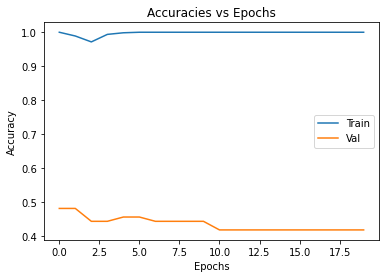

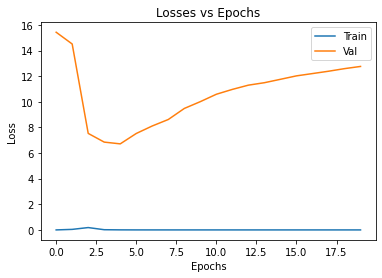

In [83]:
num_epochs = 20

model = Model(inputs = x, outputs = pred)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_history = model.fit(X_train, np.array(y_train), 
                                   epochs=num_epochs, verbose=False, validation_data=(X_val, np.array(y_val)))
    

train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']
train_accuracies = model_history.history['accuracy']
val_accuracies = model_history.history['val_accuracy']

plt.figure()
plt.title("Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Val")
plt.legend()
plt.show()

plt.figure()
plt.title("Losses vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.show()

Based on these plots, suggest a good value for the number of epochs by filling out the cell below.

In [84]:
num_epochs = 3

Using the optimal value for the number of epochs that you found above, train models with varying numbers of GRU units in the Bi-GRU layer. Make a plot of train accuracy and validation accuracy against number of GRU units and a plot of train loss and validation loss against number of GRU units. Use `[100, 200, 500, 1000, 2000]` as the values for the number of units that you are going to loop over.

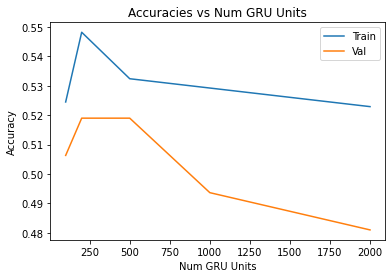

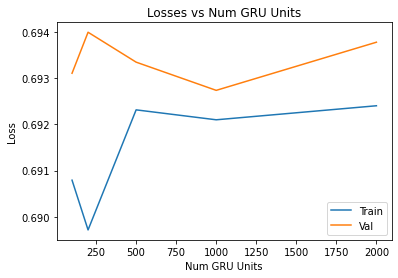

In [97]:
unit_vals = [100, 200, 500, 1000, 2000]

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for v in unit_vals:
    x = Input(shape = (X_train.shape[1], X_train.shape[2]), name="Input")
    layer1 = Dense(kappa, name="Layer1")(x)
    layer2 = Activation(softmax, name="Softmax")(layer1)
    bigru = Bidirectional(GRU(v, activation = 'relu', name="Bi-GRU"))(layer2)
    pred = Dense(1, activation = 'sigmoid', name="Sigmoid")(bigru)
    model = Model(inputs = x, outputs = pred)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, np.array(y_train), epochs=num_epochs, 
                        verbose=False, validation_data=(X_val, np.array(y_val)))
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])
    train_accuracies.append(history.history['accuracy'][-1])
    val_accuracies.append(history.history['val_accuracy'][-1])
    
plt.figure()
plt.title("Accuracies vs Num GRU Units")
plt.xlabel("Num GRU Units")
plt.ylabel("Accuracy")
plt.plot(unit_vals, train_accuracies, label="Train")
plt.plot(unit_vals, val_accuracies, label="Val")
plt.legend()
plt.show()

plt.figure()
plt.title("Losses vs Num GRU Units")
plt.xlabel("Num GRU Units")
plt.ylabel("Loss")
plt.plot(unit_vals, train_losses, label="Train")
plt.plot(unit_vals, val_losses, label="Val")
plt.legend()
plt.show()

Based on these plots, suggest a good value for the number of GRU units by filling out the cell below.

In [98]:
num_GRU_units = 500

### 4) Evaluate

Finally, train a model with the hyperparameter values that you have obtained and evaluate it on the test set! Report the test loss and accuracy.

In [106]:
x = Input(shape = (X_train.shape[1], X_train.shape[2]), name="Input")
layer1 = Dense(kappa, name="Layer1")(x)
layer2 = Activation(softmax, name="Softmax")(layer1)
bigru = Bidirectional(GRU(num_GRU_units, activation = 'relu', name="Bi-GRU"))(layer2)
pred = Dense(1, activation = 'sigmoid', name="Sigmoid")(bigru)
model = Model(inputs = x, outputs = pred)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, np.array(y_train), epochs=num_epochs, 
                        verbose=True, validation_data=(X_val, np.array(y_val)))

loss, acc = model.evaluate(X_test, np.array(y_test))

print()

print("Test loss = ", loss)
print("Test accuracy = ", acc)

Epoch 1/3
20/20 [==============================] - 1s 38ms/step - loss: 0.6944 - accuracy: 0.4803 - val_loss: 0.6931 - val_accuracy: 0.5316
Epoch 2/3
20/20 [==============================] - 1s 26ms/step - loss: 0.6929 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5316
Epoch 3/3
3/3 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5250

Test loss =  0.6920796632766724
Test accuracy =  0.5249999761581421


As you can see, our model is not doing particularly well on the test set so this method is probably not going to be very useful for price movement classification as it currently stands. Of course, there could be several reasons for the subpar performance, including but not limited to: insufficient training data, poor choice of model, poor quality of word embeddings, and bad choice of sequence length (5 days). Or perhaps, stock price classification/prediction isn't a viable goal, regardless of which neural network architecture we choose (also known asthe Random Walk Hypothesis for stock markets). Despite this unfortunate outcome, we hope that you learned something about RNNs and how they can be applied to a field like finance. Feel free to play around with these parameters to see if you can get a model worthy of use in the quantitative finance industry! 

## (Optional) Classify some more stocks!

So classifying the stock price movement for `AAPL` didn't go so well but maybe that just has something to do with Apple's stock price being unpredictable. Let's try the next stock in our dataset: another big tech company, `AMZN`. We have loaded the data for you below and you can refer to the previous sections for help with implementing and training the model. 

In [66]:
prices_amzn = pd.read_csv('AMZN.csv')